In [2]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt

# Summary statistics - raw data

In [22]:
# Functions used to read the LOB data.
# Generates the column names for the orderbook.
def gen_orderbook_colnames(n_levels):
    trade_dirs = ["ask","bid"]
    trade_attrs = ["p","s"]
    col_names = []
    for level in range(1,n_levels+1):
        for trade_dir in trade_dirs:
            for trade_attr in trade_attrs:
                col_names.append("_".join([trade_dir,
                                trade_attr,str(level)]))
    return col_names

In [95]:
# TICKERS = ["ARM", "COST", "DASH", "ISRG", "MDB", "MELI", "MU", "PANW", "PYPL", "TSLA"]
TICKERS = ["ARM","MELI","PANW"]
data_dir = "/home/mp422/data_processing/input"

type_dict = {
    1:"new_limit", 2:"partial_cancellation", 3:"total_deletion",
    4: "visible_execution",5: "hidden_execution", 6:"cross_trade", 7: "halt"}

stats_df_list = []
for TICKER in TICKERS:
    print(f"Processing: {TICKER}")
    df_list = []
    ticker_dir = os.path.join(data_dir, TICKER)
    all_files = os.listdir(ticker_dir)
    orderbook_files = [os.path.join(ticker_dir, file) for file in all_files if file.endswith("orderbook_10.csv")]
    message_files = [os.path.join(ticker_dir, file) for file in all_files if file.endswith("message_10.csv")]

    for i, message_file in enumerate(message_files):
        date = dt.datetime.strptime(message_file.split("_")[2], "%Y-%m-%d").date()
        print(f"Processing date: {date}")

        orderbook_df = pd.read_csv(orderbook_files[i], names=gen_orderbook_colnames(n_levels=10))
        message_df = pd.read_csv(message_file, names=["time","type","order_id","size","price",
        "trade_direction","trade_type"], dtype={"trade_type": "str"})
        df = pd.concat([message_df,orderbook_df], axis=1)
        df["price_diff"] = df["price"].diff().fillna(0)
        df["is_price_change"] = np.where(df["price_diff"] == 0, 0, 1)
        
        updates = df.shape[0] / 1e3
        trades = df["type"].apply(lambda t: 1 if type_dict[t] == "visible_execution" else 0).sum() / 1e3
        price_changes = df["is_price_change"].sum() / 1e3
        price = df["price"].mean() / 1e4
        spread = (orderbook_df["ask_p_1"] - orderbook_df["bid_p_1"]).mean() / 1e4
        volume = (df[df["type"].apply(lambda t: type_dict[t]) == "visible_execution"]["size"] * df[df["type"].apply(lambda t: type_dict[t]) == "visible_execution"]["price"]).sum() / (1e4 * 1e6)
        
        stats_df = pd.DataFrame(
            {
                "ticker":TICKER,
                "date":date,
                "updates": [updates],
                "trades": [trades],
                "price_changes": [price_changes],
                "price": [price],
                "spread": [spread],
                "volume": [volume]
            }
        )
    
        stats_df_list.append(stats_df)

Processing: ARM
Processing date: 2024-05-24
Processing date: 2024-05-28
Processing date: 2024-05-29
Processing date: 2024-05-30
Processing date: 2024-05-31
Processing date: 2024-06-03
Processing date: 2024-06-04
Processing date: 2024-06-05
Processing date: 2024-06-06
Processing date: 2024-06-07
Processing date: 2024-06-10
Processing date: 2024-06-11
Processing date: 2024-06-12
Processing date: 2024-06-13
Processing date: 2024-06-14
Processing date: 2024-06-17
Processing date: 2024-06-18
Processing date: 2024-06-20
Processing date: 2024-06-21
Processing date: 2024-06-24
Processing: MELI
Processing date: 2024-05-24
Processing date: 2024-05-28
Processing date: 2024-05-29
Processing date: 2024-05-30
Processing date: 2024-05-31
Processing date: 2024-06-03
Processing date: 2024-06-04
Processing date: 2024-06-05
Processing date: 2024-06-06
Processing date: 2024-06-07
Processing date: 2024-06-10
Processing date: 2024-06-11
Processing date: 2024-06-12
Processing date: 2024-06-13
Processing date

In [96]:
daily_stats_df = pd.concat(stats_df_list)

In [97]:
daily_stats_df.groupby("ticker", as_index=False).mean()

,ticker,updates,trades,price_changes,price,spread,volume
0,ARM,198.9068,25.37160,160.25180,140.516997,0.121357,233.236919
1,MELI,74.5086,2.56800,60.39945,1626.912685,2.227429,51.331381
2,PANW,128.8557,11.69845,101.31750,307.907958,0.178800,115.227508


# Price changes analysis

In [31]:
quantiles = [0.1,0.2,0.3,0.4,0.5]

In [32]:
# TICKERS = ["ARM", "COST", "DASH", "ISRG", "MDB", "MELI", "MU", "PANW", "PYPL", "TSLA"]
TICKERS = ["MELI","PANW","ARM"]
data_dir = "/home/mp422/data_processing/input"

type_dict = {
    1:"new_limit", 2:"partial_cancellation", 3:"total_deletion",
    4: "visible_execution",5: "hidden_execution", 6:"cross_trade", 7: "halt"}

quantile_df_list = []
for TICKER in TICKERS:
    print(f"Processing: {TICKER}")
    ticker_dir = os.path.join(data_dir, TICKER)
    all_files = os.listdir(ticker_dir)
    message_files = [os.path.join(ticker_dir, file) for file in all_files if file.endswith("message_10.csv")]

    for i, message_file in enumerate(message_files):
        date = dt.datetime.strptime(message_file.split("_")[2], "%Y-%m-%d").date()
        print(f"Processing date: {date}")
        df = pd.read_csv(message_file, names=["time","type","order_id","size","price",
        "trade_direction","trade_type"], dtype={"trade_type": "str"})
        df["price_diff"] = df["price"].diff().fillna(0)
        df["is_price_change"] = np.where(df["price_diff"] == 0, 0, 1)
        df["price_change_count"] = np.cumsum(df["is_price_change"])
        df["price_change_count_shift"] = df["price_change_count"].shift(1).fillna(0)
        start_df = df.groupby("price_change_count", as_index=False).agg(start_time=("time","min"))
        end_df = df.groupby("price_change_count_shift", as_index=False).agg(end_time=("time","max"))
        end_df.rename(columns={"price_change_count_shift":"price_change_count"},inplace=True)
        delta_df = start_df.merge(end_df, on="price_change_count", how="inner")
        delta_df["time_between_price_changes"] = delta_df["end_time"] - delta_df["start_time"]
        # Converts to microseconds
        delta_df["time_between_price_changes"] = delta_df["time_between_price_changes"] * 1e6
        delta_df.insert(0,"ticker",TICKER)
        delta_df.insert(1,"date",date)

    price_changes_quantiles = np.quantile(delta_df["time_between_price_changes"],quantiles)

    quantile_df = pd.DataFrame({
        "ticker": [TICKER]
    })

    quantile_df[[str(q) for q in quantiles]] = price_changes_quantiles

    quantile_df_list.append(quantile_df)

Processing: MELI
Processing date: 2024-05-24
Processing date: 2024-05-28
Processing date: 2024-05-29
Processing date: 2024-05-30
Processing date: 2024-05-31
Processing date: 2024-06-03
Processing date: 2024-06-04
Processing date: 2024-06-05
Processing date: 2024-06-06
Processing date: 2024-06-07
Processing date: 2024-06-10
Processing date: 2024-06-11
Processing date: 2024-06-12
Processing date: 2024-06-13
Processing date: 2024-06-14
Processing date: 2024-06-17
Processing date: 2024-06-18
Processing date: 2024-06-20
Processing date: 2024-06-21
Processing date: 2024-06-24
Processing: PANW
Processing date: 2024-05-24
Processing date: 2024-05-28
Processing date: 2024-05-29
Processing date: 2024-05-30
Processing date: 2024-05-31
Processing date: 2024-06-03
Processing date: 2024-06-04
Processing date: 2024-06-05
Processing date: 2024-06-06
Processing date: 2024-06-07
Processing date: 2024-06-10
Processing date: 2024-06-11
Processing date: 2024-06-12
Processing date: 2024-06-13
Processing dat

In [33]:
quantile_analysis_df = pd.concat(quantile_df_list)

In [34]:
quantile_analysis_df

,ticker,0.1,0.2,0.3,0.4,0.5
0,MELI,7.406203,36.980199,121.856001,841.236200,8490.314998
0,PANW,1.274401,22.112404,57.064403,247.949596,993.084999
0,ARM,8.229799,28.632401,76.789797,354.409800,1471.429998


# Time analsysis

In [3]:
# TICKERS = ["ARM", "COST", "DASH", "ISRG", "MDB", "MELI", "MU", "PANW", "PYPL", "TSLA"]
TICKERS = ["ARM","MELI","PANW"]
data_dir = "/home/mp422/data_processing/data"

desc_df_list = []
for TICKER in TICKERS:
    print(f"Processing: {TICKER}")
    df_list = []
    ticker_dir = os.path.join(data_dir, TICKER)
    all_files = os.listdir(ticker_dir)
    npz_files = [os.path.join(ticker_dir, file) for file in all_files if file.endswith(".npz")]

    for i, npz_file in enumerate(npz_files):
        date = dt.datetime.strptime(npz_file.split("_")[-1].split(".")[0], "%Y-%m-%d").date()
        
        data = np.load(npz_file)
        df = pd.DataFrame({"timestamp": data["timestamps"]})
        df["timestamp_diff"] = df["timestamp"].diff()
        df.insert(0, "ticker", TICKER)
        df.insert(1, "date", date)
        df_list.append(df)
    timestamps_df = pd.concat(df_list)
    desc_df = pd.DataFrame(timestamps_df["timestamp_diff"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95])).rename(columns={"timestamp_diff":TICKER}).T
    desc_df_list.append(desc_df)

all_desc_df = pd.concat(desc_df_list)

Processing: ARM
Processing: MELI
Processing: PANW


In [4]:
all_desc_df.sort_values("count", inplace=True)

In [5]:
all_desc_df

,count,mean,std,min,5%,25%,50%,75%,95%,max
MELI,1111086.0,0.393478,1.211625,1.189983e-07,0.000001,0.000038,0.001677,0.139023,2.276727,49.855331
PANW,2009501.0,0.217570,0.655489,1.259978e-07,0.000003,0.000040,0.000769,0.100015,1.211033,28.438561
ARM,3153933.0,0.138622,0.443623,1.279986e-07,0.000003,0.000033,0.000498,0.037101,0.815081,25.261216


In [9]:
metrics = ["mean"]

horizon_proj_df = all_desc_df[metrics].copy()

horizons = np.array([10, 1000, 10000])

for horizon in horizons:
    for metric in metrics:
        horizon_proj_df[f"h={horizon}_" + metric] = horizon_proj_df[metric] * horizon / 60

horizon_proj_df

,mean,h=10_mean,h=1000_mean,h=10000_mean
MELI,0.393478,0.065580,6.557962,65.579618
PANW,0.217570,0.036262,3.626172,36.261722
ARM,0.138622,0.023104,2.310369,23.103687


# Trend analysis

In [20]:
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt

In [17]:
# TICKERS = ["ARM", "COST", "DASH", "ISRG", "MDB", "MELI", "MU", "PANW", "PYPL", "TSLA"]
TICKERS = ["MELI","PANW","ARM"]
data_dir = "/home/mp422/data_processing/input"

type_dict = {
    1:"new_limit", 2:"partial_cancellation", 3:"total_deletion",
    4: "visible_execution",5: "hidden_execution", 6:"cross_trade", 7: "halt"}

price_df_list = []
for TICKER in TICKERS:
    print(f"Processing: {TICKER}")
    ticker_dir = os.path.join(data_dir, TICKER)
    all_files = os.listdir(ticker_dir)
    message_files = [os.path.join(ticker_dir, file) for file in all_files if file.endswith("message_10.csv")]

    for i, message_file in enumerate(message_files):
        date = dt.datetime.strptime(message_file.split("_")[2], "%Y-%m-%d").date()
        print(f"Processing date: {date}")
        df = pd.read_csv(message_file, names=["time","type","order_id","size","price",
        "trade_direction","trade_type"], dtype={"trade_type": "str"})
        closing_price = df["price"][len(df) - 1]

        price_df = pd.DataFrame(
            {
                "ticker": [TICKER],
                "date": [date],
                "closing_price": [closing_price]
            }
        )

        price_df_list.append(price_df)

Processing: MELI
Processing date: 2024-05-24
Processing date: 2024-05-28
Processing date: 2024-05-29
Processing date: 2024-05-30
Processing date: 2024-05-31
Processing date: 2024-06-03
Processing date: 2024-06-04
Processing date: 2024-06-05
Processing date: 2024-06-06
Processing date: 2024-06-07
Processing date: 2024-06-10
Processing date: 2024-06-11
Processing date: 2024-06-12
Processing date: 2024-06-13
Processing date: 2024-06-14
Processing date: 2024-06-17
Processing date: 2024-06-18
Processing date: 2024-06-20
Processing date: 2024-06-21
Processing date: 2024-06-24
Processing: PANW
Processing date: 2024-05-24
Processing date: 2024-05-28
Processing date: 2024-05-29
Processing date: 2024-05-30
Processing date: 2024-05-31
Processing date: 2024-06-03
Processing date: 2024-06-04
Processing date: 2024-06-05
Processing date: 2024-06-06
Processing date: 2024-06-07
Processing date: 2024-06-10
Processing date: 2024-06-11
Processing date: 2024-06-12
Processing date: 2024-06-13
Processing dat

In [18]:
price_summary_df = pd.concat(price_df_list)

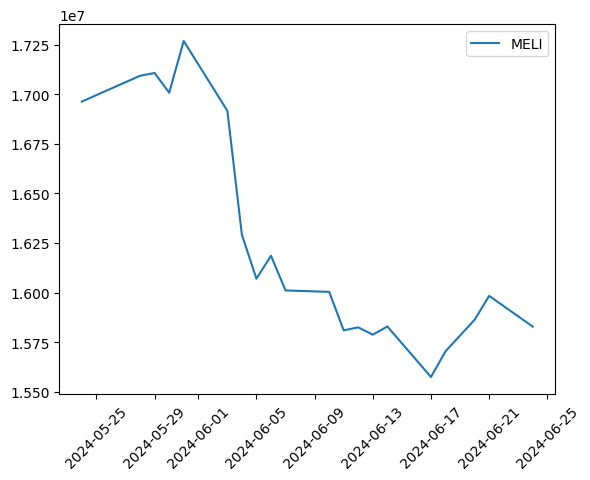

In [30]:
ticker = "MELI"
plot_df = price_summary_df[price_summary_df["ticker"] == ticker].copy()
plt.plot(plot_df["date"], plot_df["closing_price"], label=ticker)
plt.legend()
plt.xticks(rotation=45)
plt.plot();

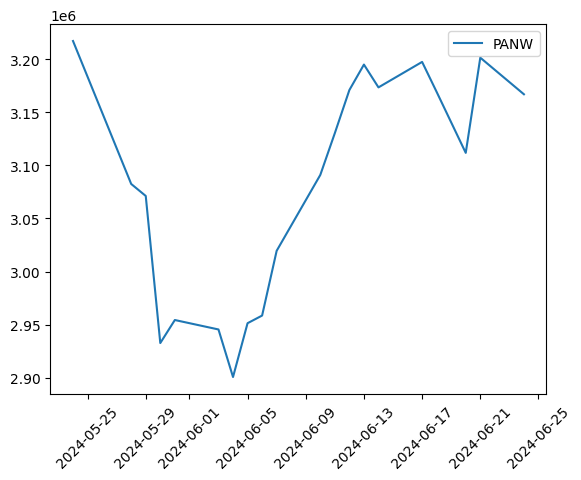

In [31]:
ticker = "PANW"
plot_df = price_summary_df[price_summary_df["ticker"] == ticker].copy()
plt.plot(plot_df["date"], plot_df["closing_price"], label=ticker)
plt.legend()
plt.xticks(rotation=45)
plt.plot();

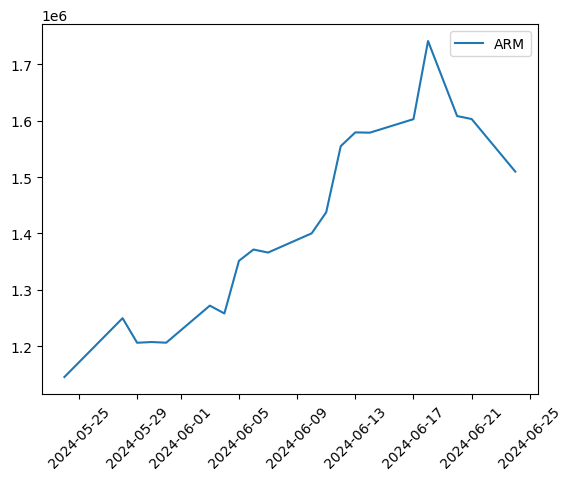

In [32]:
ticker = "ARM"
plot_df = price_summary_df[price_summary_df["ticker"] == ticker].copy()
plt.plot(plot_df["date"], plot_df["closing_price"], label=ticker)
plt.legend()
plt.xticks(rotation=45)
plt.plot();